数据网站，https://www.nasdaq.com/market-activity/quotes/historical

## Library

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


## Data Plot

[ 29.4228  28.6443  28.56   ... 264.47   262.64   265.76  ]


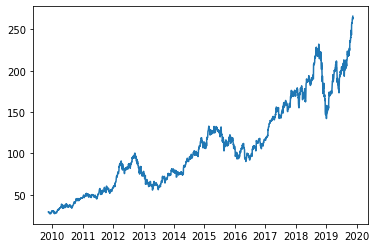

In [165]:
data = pd.read_csv('data/nasdaq/AAPL.csv', converters={
    0:lambda x:datetime.strptime(x, '%m/%d/%Y')
})

data = data.sort_index(ascending=False)

training_set = data.iloc[:,1].values
timeline = data.iloc[:,0].values
print(training_set)

plt.plot(timeline, training_set, )

plt.show()

## Dataloading

In [158]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set.reshape(-1, 1))
# print(training_data)

seq_length = 5
x, y = sliding_windows(training_data, seq_length)


train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
# print(trainX)
# print(trainY)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


# print(training_data)
# print(trainX)
# print(trainY)

## Model

In [159]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)#, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [160]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
#       print(outputs)
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05738
Epoch: 500, loss: 0.00007
Epoch: 1000, loss: 0.00005
Epoch: 1500, loss: 0.00004


## Testing for Global CO2 Monthly Dataset

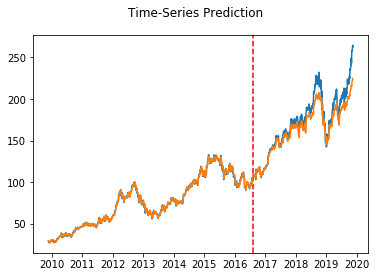

In [164]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()
# print(dataY_plot)
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
# print(len(dataY_plot[:, 0]))

tx, ty = sliding_windows(timeline, seq_length)

plt.axvline(x=ty[train_size], c='r', linestyle='--')

plt.plot(ty, dataY_plot, )
plt.plot(ty, data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()